In [42]:
import numpy as np
import pandas as pd
import zipfile
import requests
import io
import seaborn as sns
from math import floor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

**Dicionário de dados:**



*  Survived: Passageiro que sobreviveu (0 = Não, 1 = Sim)
*  Pclass: Classe de ingresso do passageiro (1 = 1ª classe, 2 = 2ª classe, 3 = 3ª classe)
*  Sex: Sexo do passageiro
*  Age: Idade em anos do passageiro
*  Sibsp: Quantidade de irmãos / cônjuges a bordo do Titanic
*  Parch: Quantidade de pais / crianças a bordo do Titanic
*  Ticket: Número do bilhete de embarque do passageiro
*  Fare: Tarifa paga pelo passageiro
*  Cabin: Número de cabine
*  Embarked (Embarque): Porto de Embarque (C = Cherbourg, Q = Queenstown, S = Southampton)













**Criação do DataFrame de treino:**

In [43]:
trainDF = pd.read_csv('https://raw.githubusercontent.com/laripaiva/kaggle-titanic-challenge/master/data/train.csv')
trainDF.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Criação do DataFrame de teste:**

In [44]:
testDF = pd.read_csv('https://raw.githubusercontent.com/laripaiva/kaggle-titanic-challenge/master/data/test.csv')
test_y = pd.read_csv('https://raw.githubusercontent.com/laripaiva/kaggle-titanic-challenge/master/data/gender_submission.csv')
testDF['Survived'] = test_y['Survived']
testDF.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0


**Após analisar o conteúdo e descrição das colunas do dataset, foram descartadas as colunas PassengerId, Name e Ticket.**

In [45]:
trainDF = trainDF.drop(['Name', 'Ticket','Cabin'], axis=1)
testDF = testDF.drop(['Name', 'Ticket','Cabin'], axis=1)

**Verificação de dados ausentes em cada coluna (dados de treino):**

In [46]:
trainDF.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

****Verificação de dados ausentes em cada coluna (dados de teste):****

In [47]:
testDF.isnull().sum() 

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
Survived        0
dtype: int64

**Substituindo dados ausentes da coluna Age (dados de treino):**

Cada dado nulo será substituído por um número aleatório, calculado com base na média das idades e o desvio padrão dessa coluna.


In [48]:
mean = trainDF["Age"].mean()
std = trainDF["Age"].std()

for index,value in enumerate(trainDF['PassengerId']):
  if pd.isnull(trainDF['Age'][index]):
    trainDF['Age'][index] = np.random.randint(mean - std, mean + std, size = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Substituindo dados ausentes da coluna Age (dados de teste):**


Cada dado nulo será substituído por um número aleatório, calculado com base na média das idades e o desvio padrão dessa coluna.


In [49]:
mean = testDF["Age"].mean()
std = testDF["Age"].std()

for index,value in enumerate(testDF['PassengerId']):
  if pd.isnull(testDF['Age'][index]):
    testDF['Age'][index] = np.random.randint(mean - std, mean + std, size = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Substituindo dados ausentes da coluna Embarked (dados de treino):**

Cada dado nulo será substituído pelo valor mais frequente na determinada coluna.

In [50]:
trainDF = trainDF.fillna(trainDF['Embarked'].value_counts().index[0])

**Substituindo dados ausentes da coluna Fare (dados de teste):**

Cada dado nulo será substituído pelo valor mais frequente na determinada coluna.

In [51]:
testDF = testDF.fillna(testDF['Fare'].value_counts().index[0]) 

**Encoder da coluna Sex:**

In [52]:
trainDF["Sex"] = trainDF["Sex"].map({'female':0,'male':1})
testDF["Sex"] = testDF["Sex"].map({'female':0,'male':1})

**Encoder da coluna Embarked:**

In [53]:
trainDF["Embarked"] = trainDF["Embarked"].map({'C':0,'Q':1,'S':2})
testDF["Embarked"] = testDF["Embarked"].map({'C':0,'Q':1,'S':2})

**Arredondando a idade dos passageiros:**

In [54]:
trainDF['Age'] = trainDF['Age'].apply(np.floor)
testDF['Age'] = testDF['Age'].apply(np.floor)

**Quantidade de sobreviventes e vítimas (dados de treino):**

In [55]:
survivors= (trainDF.groupby('Survived').size())[0]
victims = (trainDF.groupby('Survived').size())[1]
print('Sobreviventes:',survivors)
print('Vítimas:',victims)

Sobreviventes: 549
Vítimas: 342


**Para visualizar melhor as informações dos sobreviventes, foram elaborados os seguintes gráficos:**

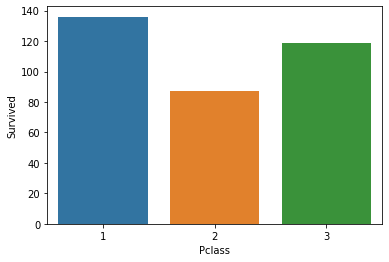

In [56]:
groupedValues = trainDF[['Survived','Pclass']].groupby('Pclass').sum().reset_index()
sns.barplot(x='Pclass',y='Survived',data=groupedValues)

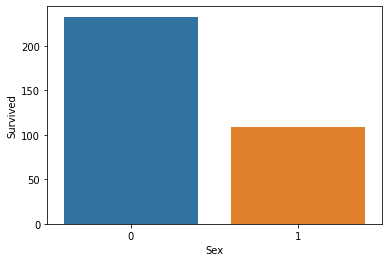

In [57]:
groupedValues = trainDF[['Survived','Sex']].groupby('Sex').sum().reset_index()
sns.barplot(x='Sex',y='Survived',data=groupedValues)

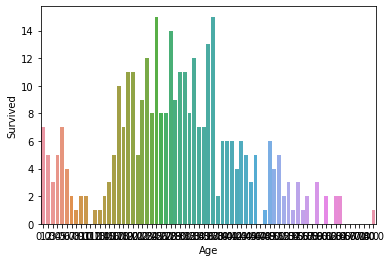

In [58]:
groupedValues = trainDF[['Survived','Age']].groupby('Age').sum().reset_index()
sns.barplot(x='Age',y='Survived',data=groupedValues)

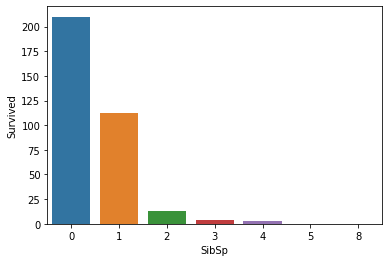

In [59]:
groupedValues = trainDF[['Survived','SibSp']].groupby('SibSp').sum().reset_index()
sns.barplot(x='SibSp',y='Survived',data=groupedValues)

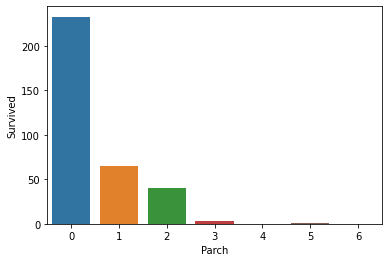

In [60]:
groupedValues = trainDF[['Survived','Parch']].groupby('Parch').sum().reset_index()
sns.barplot(x='Parch',y='Survived',data=groupedValues)

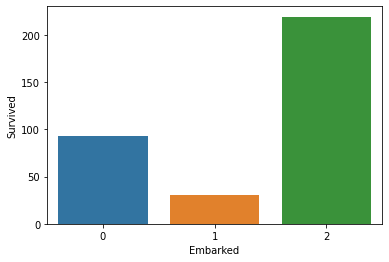

In [61]:
groupedValues = trainDF[['Survived','Embarked']].groupby('Embarked').sum().reset_index()
sns.barplot(x='Embarked',y='Survived',data=groupedValues)

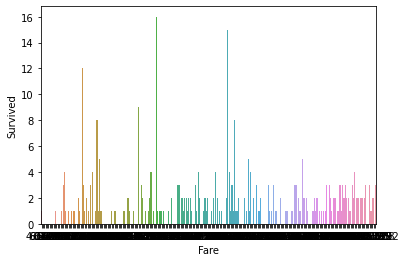

In [62]:
groupedValues = trainDF[['Survived','Fare']].groupby('Fare').sum().reset_index()
sns.barplot(x='Fare',y='Survived',data=groupedValues)

**Matriz de correlação das variáveis:**

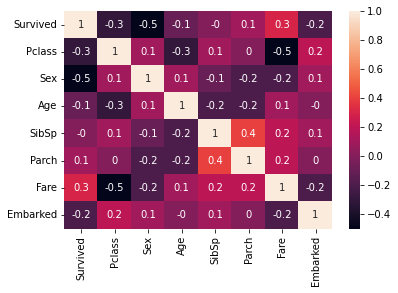

In [63]:
correlationMatrix = trainDF[['Survived', 'Pclass', 'Sex', 'Age','SibSp','Parch','Fare','Embarked']].corr().round(1)
sns.heatmap(data=correlationMatrix, annot=True)

In [64]:
features = ['Pclass', 'Sex', 'Age','SibSp','Parch','Fare','Embarked']
target = ['Survived']

**O desafio no Kaggle sugeria que fossem apontados quais foram os sobreviventes deste naufrágio. Dessa forma, foi elaborado um modelo que indica a probabilidade um passageiro ter sobrevivido ou não ao naufrágio.**

In [65]:
passengerToPredict = pd.DataFrame({
    'Pclass': 3, 
    'Sex': 0, 
    'Age': 20,
    'SibSp': 0,
    'Parch': 0,
    'Fare': 7.0000,
    'Embarked':1,
}, index=[0])

**Classificação com Árvore de Decisão:**

In [66]:
classifierDF = DecisionTreeClassifier(criterion="entropy", max_depth=3)
classifierDF.fit(trainDF[features], trainDF[target])
testPredictionDF = classifierDF.predict(testDF[features]) 
accuracyDF = accuracy_score(testDF[target], testPredictionDF)
print('A acurácia desse modelo pela Árvore de Decisão é de: ', (accuracyDF*100).round(1),'%')

A acurácia desse modelo pela Árvore de Decisão é de:  96.2 %


In [67]:
classifierDF.predict(passengerToPredict) 
classificationProbabilityDF = classifierDF.predict_proba(passengerToPredict) 
pd.DataFrame(classificationProbabilityDF, columns=('Não', 'Sim'))

,Não,Sim
0,0.410256,0.589744


**Classificação com Naive Bayes:**

In [68]:
classifierNB = GaussianNB()
classifierNB.fit(trainDF[features], trainDF[target])
testPredictionNB = classifierNB.predict(testDF[features]) 
accuracyNB = accuracy_score(testDF[target], testPredictionNB)
print('A acurácia desse modelo pelo Naive Bayes é de: ', (accuracyNB*100).round(1),'%')

A acurácia desse modelo pelo Naive Bayes é de:  89.7 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
classifierNB.predict(passengerToPredict) 
classificationProbabilityNB = classifierNB.predict_proba(passengerToPredict) 
pd.DataFrame(classificationProbabilityNB, columns=('Não', 'Sim'))

,Não,Sim
0,0.275238,0.724762


**Classificação com Regressão Logística:**

In [70]:
classifierLR = LogisticRegression(solver='lbfgs', max_iter=1000)
classifierLR.fit(trainDF[features], trainDF[target])
testPredictionLR = classifierLR.predict(testDF[features]) 
accuracyLR = accuracy_score(testDF[target], testPredictionLR)
print('A acurácia desse modelo de Regressão Logística: ', (accuracyLR*100).round(1),'%')

A acurácia desse modelo de Regressão Logística:  93.8 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
classifierLR.predict(passengerToPredict) 
classificationProbabilityLR = classifierLR.predict_proba(passengerToPredict) 
pd.DataFrame(classificationProbabilityLR, columns=('Não', 'Sim'))

,Não,Sim
0,0.281029,0.718971
